# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT TP. HCM
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU
<br/>

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY DỰ ĐOÁN GIÁ NÔNG SẢN

<br/>

<p>Họ và tên Sinh viên 1 : Huỳnh Hạo Nhị MSSV 1: 20133006 <p>
<br/>
Họ và tên Sinh viên 2 : Võ Hoài Thương MSSV 2: 20133012

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

## Dữ liệu

In [2]:
RICE_URI = "https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Cam/gia_cam.csv"

In [3]:
df_rice = pd.read_csv(RICE_URI)

In [4]:
df_rice.head()

,date,price
0,7/17/2007,16000
1,7/18/2007,16000
2,7/19/2007,16000
3,7/20/2007,16000
4,7/21/2007,16000


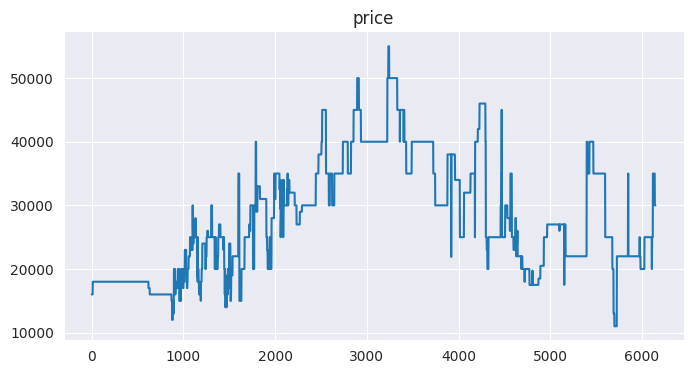

In [5]:
# @title EDA Data

from matplotlib import pyplot as plt
df_rice['price'].plot(kind='line', figsize=(8, 4), title='price')
plt.gca().spines[['top', 'right']].set_visible(False)

In [6]:
df_rice.set_index('date', inplace=True)

In [7]:
df_rice.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6148 entries, 7/17/2007 to 5/15/2024
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   price   6148 non-null   int64
dtypes: int64(1)
memory usage: 96.1+ KB


### Xử lí outlier

<Axes: >

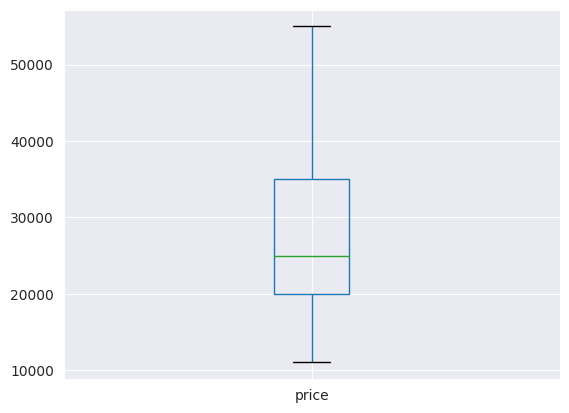

In [8]:
df_rice.boxplot()

In [9]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df_rice['price'].quantile(0.25)
Q3 = df_rice['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df_rice[(df_rice['price'] < lower_bound) | (df_rice['price'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df_rice.at[df_rice.index[0], 'price'] = min(max(df_rice.iloc[0]['price'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df_rice.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df_rice.index[previous_date_index]
        previous_value = df_rice.loc[previous_date, 'price']
        df_rice.at[index, 'price'] = previous_value

Số lượng outlier: 0


<Axes: >

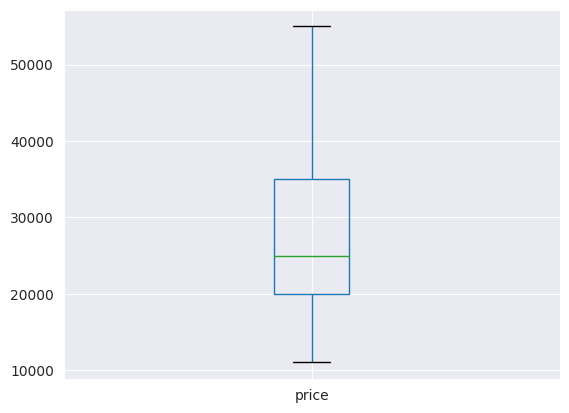

In [10]:
df_rice.boxplot()

<Axes: xlabel='date'>

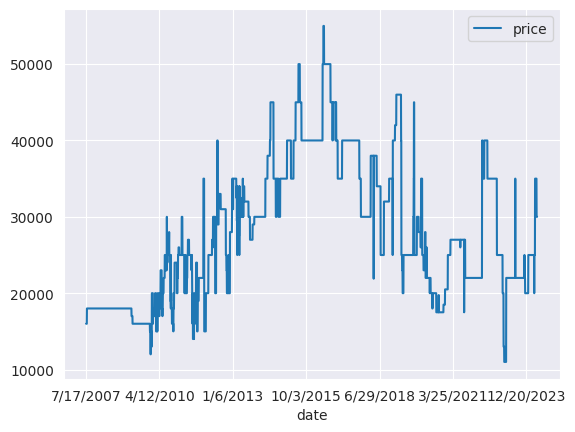

In [11]:
df_rice.plot()

### Smothing Data

Moving average smoothing: Giá trị tại một điểm dữ liệu sẽ được tính bằng trung bình k giá trị phía trước. 

In [12]:
df_rice = df_rice.rolling(30).mean()
df_rice = df_rice.dropna()

<Axes: xlabel='date'>

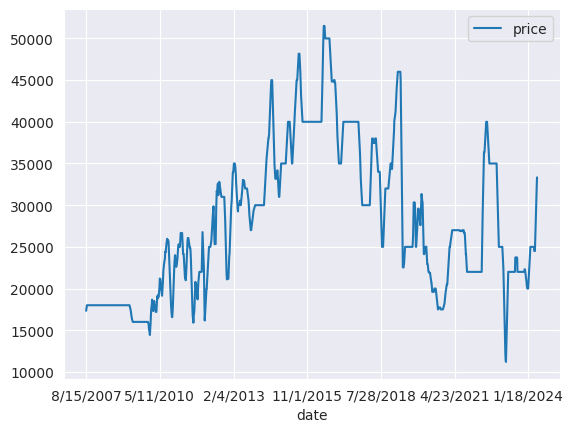

In [13]:
df_rice.plot()

# Kiểm tra tính dừng

Tiếp theo, chúng tôi kiểm tra tính dừng (stationarity), lấy sai phân (differencing) cho dữ liệu bằng các phương pháp như Random Walk Model, Second-Order Differencing, Seasonal Differencing, Augmented Dickey-Fuller.

Phân rã chuỗi thời gian thành các thành phần (decomposition) mang tính xu hướng, mùa vụ hoặc chu kỳ. 

In [14]:
def test_stationarity(timeseries):

    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=1).mean()
    movingSTD = timeseries.rolling(window=1).std()

    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)

    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

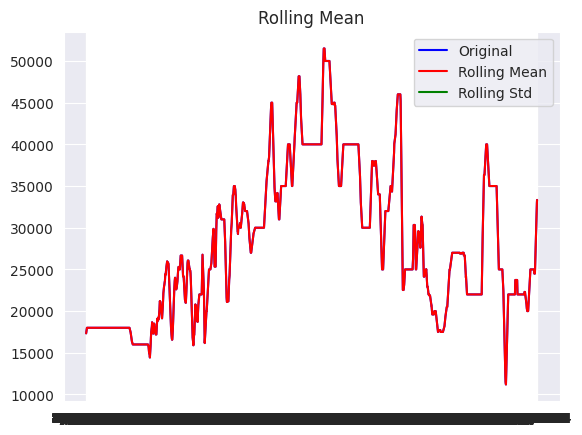

Results of Dickey Fuller Test:
Test Statistic                   -3.317367
p-value                           0.014120
#Lags Used                       31.000000
Number of Observations Used    6087.000000
Critical Value (1%)              -3.431425
Critical Value (5%)              -2.862015
Critical Value (10%)             -2.567023
dtype: float64


In [15]:
test_stationarity(df_rice.price)

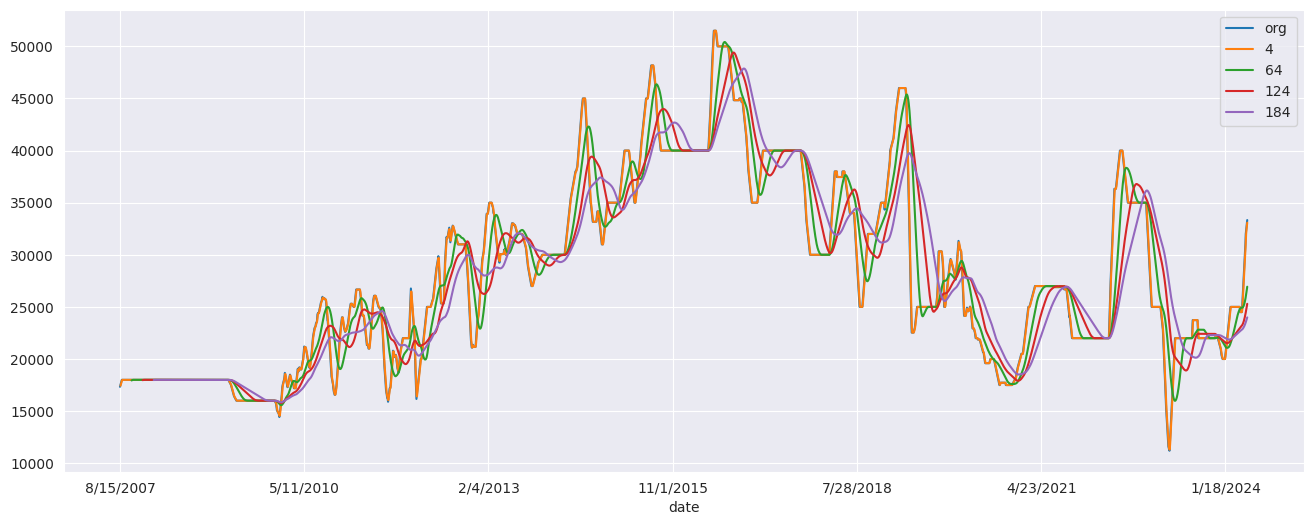

In [16]:
plt.figure(figsize=(16,6))
df_rice.price.plot(label="org")
for i in range(4,200,60):
    df_rice["price"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

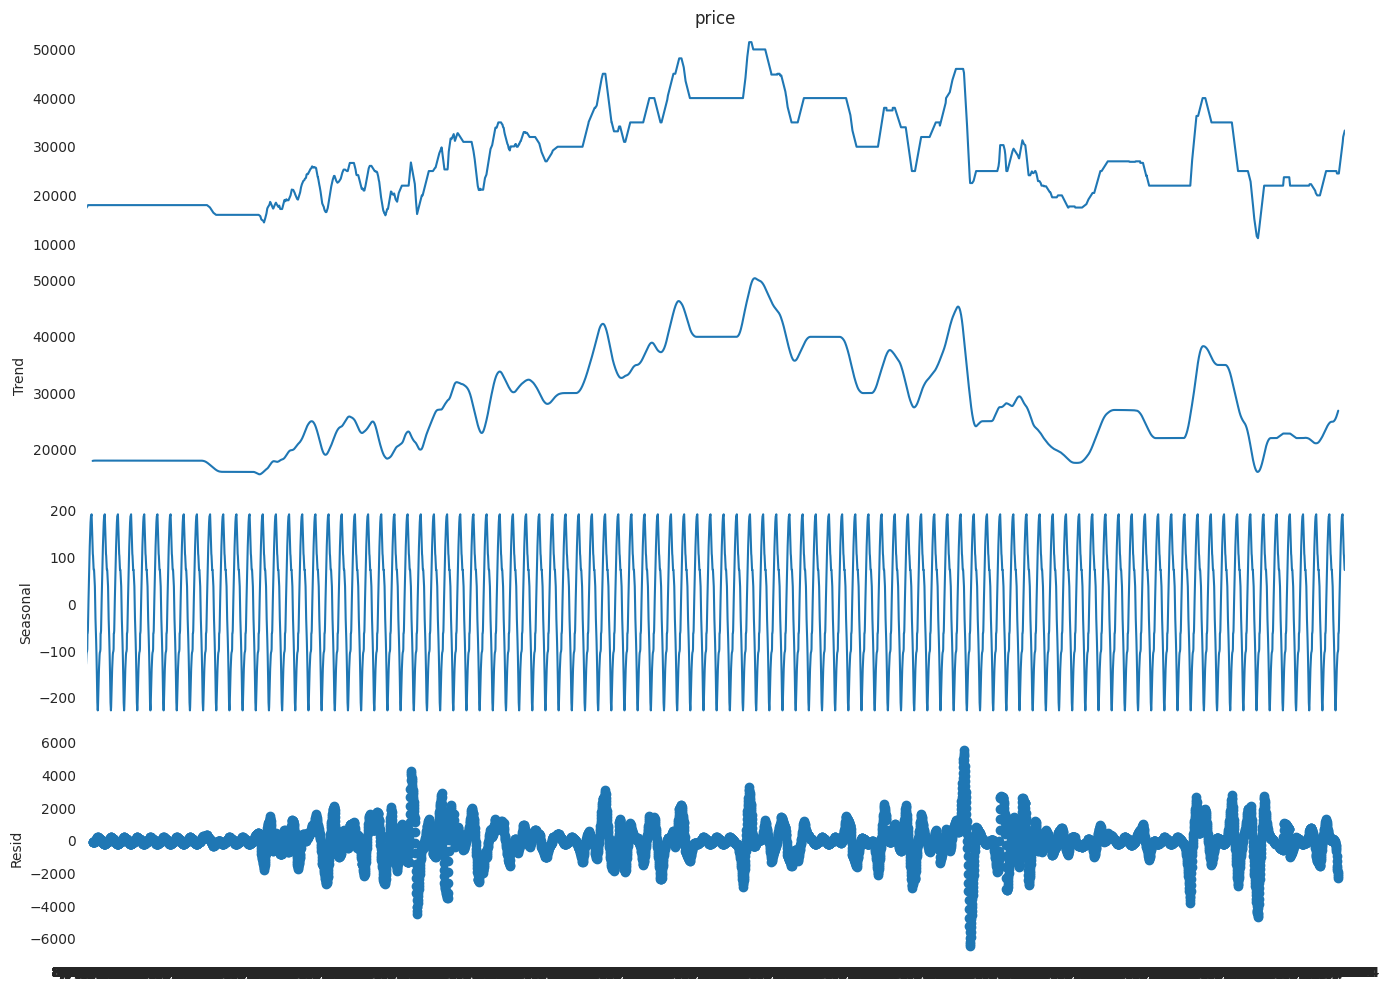

In [17]:
decompose_ts_add = seasonal_decompose(df_rice.price,period=64)
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

In [18]:
from statsmodels.tsa.stattools import pacf
pacf(df_rice.price, nlags=10)

array([ 1.        ,  0.99987922, -1.03251546, -1.40936243,  1.91448075,
        0.9659174 ,  7.40365196, -1.05491771, -1.3354661 ,  2.23946944,
        0.87659466])

In [19]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,6))
    tsa_plots.acf(df_rice.price, nlags=10)
    plt.show()

In [20]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result = adfuller(series.dropna())
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [21]:
df1 = df_rice.price.copy()

### Các phương pháp thường được sử dụng

In [22]:
# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

In [23]:
# invert differenced forecast
def inverse_difference(last_ob, value):
  return value + last_ob

In [24]:
diff = difference(df1, 60)

In [25]:
from matplotlib import pyplot

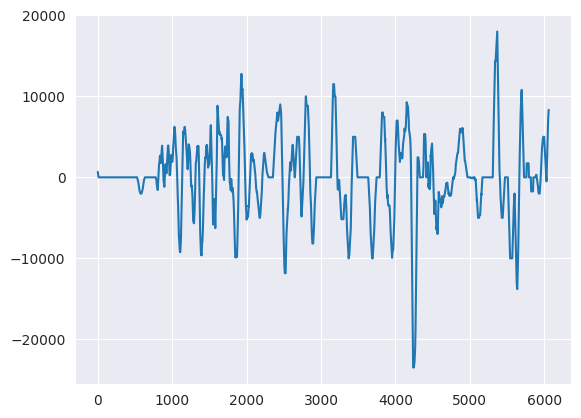

In [26]:
pyplot.plot(diff)
pyplot.show()

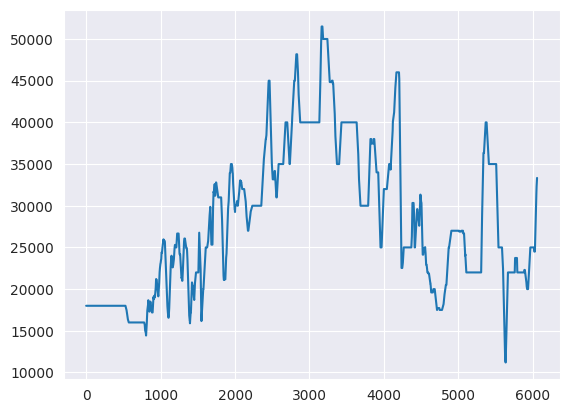

In [27]:
# invert the difference
inverted = [inverse_difference(df1[i], diff[i]) for i in range(len(diff))]
pyplot.plot(inverted)
pyplot.show()

In [29]:
def revert_tranform_seasonal(df):
  return df + df.shift(60)

<Axes: xlabel='date'>

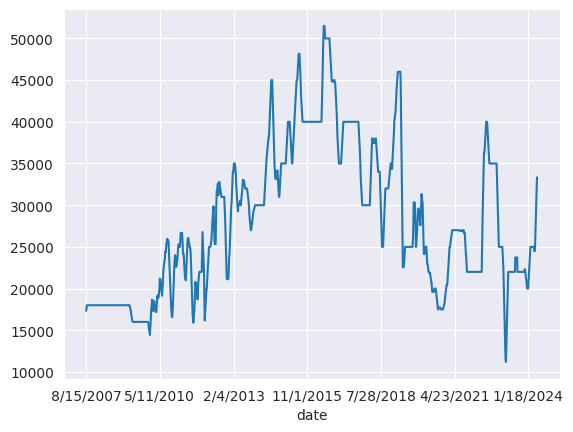

In [31]:
df1.plot()

In [33]:
def revert_tranform_seasonal(df):
  return np.square(df)

In [35]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.4 MB/s eta 0:00:00


In [36]:
df_rice.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6119 entries, 8/15/2007 to 5/15/2024
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   6119 non-null   float64
dtypes: float64(1)
memory usage: 95.6+ KB


In [37]:
df1 = df1.copy()

In [38]:
# df1['price'] = df_rice["price"].rolling(60).mean()

In [39]:
df1

date
8/15/2007    17333.333333
8/16/2007    17400.000000
8/17/2007    17466.666667
8/18/2007    17533.333333
8/19/2007    17600.000000
                 ...     
5/11/2024    32666.666667
5/12/2024    32833.333333
5/13/2024    33000.000000
5/14/2024    33166.666667
5/15/2024    33333.333333
Name: price, Length: 6119, dtype: float64

In [40]:
df1 = df1.dropna()


In [41]:
df1.info()

<class 'pandas.core.series.Series'>
Index: 6119 entries, 8/15/2007 to 5/15/2024
Series name: price
Non-Null Count  Dtype  
--------------  -----  
6119 non-null   float64
dtypes: float64(1)
memory usage: 95.6+ KB


In [42]:
size = int(len(df1) * 0.7)
train_data = df1[:size]
test_data = df1[size:]

In [43]:
train_data =  train_data.diff()

In [44]:
train_data = train_data.dropna()

In [45]:
train_data.info()

<class 'pandas.core.series.Series'>
Index: 4282 entries, 8/16/2007 to 5/6/2019
Series name: price
Non-Null Count  Dtype  
--------------  -----  
4282 non-null   float64
dtypes: float64(1)
memory usage: 66.9+ KB


In [46]:
adf_test(train_data)

Reject the null hypothesis
Data is stationary


<Axes: xlabel='date'>

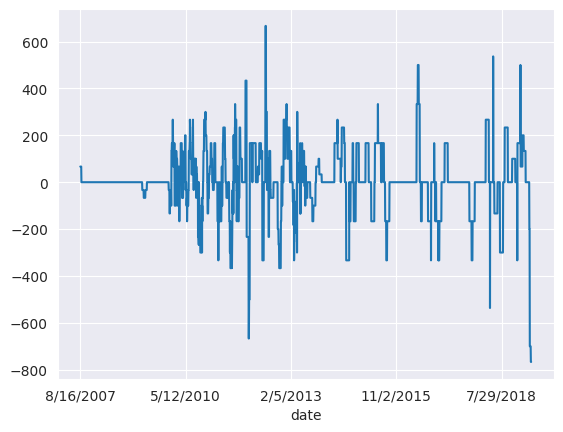

In [47]:
train_data.plot()

In [48]:
diff_data = train_data.copy()
diff_data.iloc[0] = train_data.iloc[0]

# Compute the cumulative sum to revert the diff transformation
reverted_data = diff_data.cumsum()

<Axes: xlabel='date'>

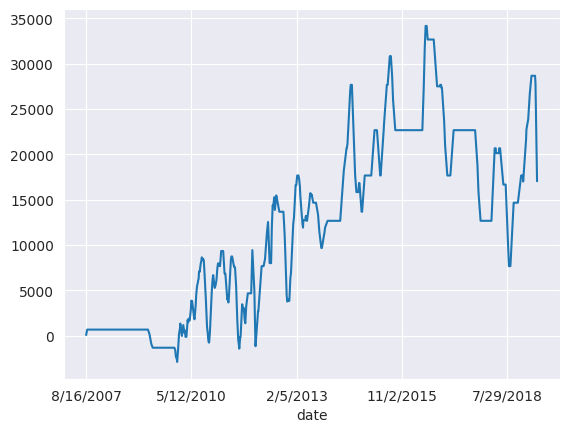

In [49]:
reverted_data.plot()

In [50]:
size

4283

In [51]:
train_data.values

array([  66.66666667,   66.66666667,   66.66666667, ..., -766.66666667,
       -766.66666667, -766.66666667])

## ARIMA MODEL

Chúng tôi sử dụng phương pháp điều chỉnh tham số bằng cách lặp qua các bộ tham số tương tứng (p, d, q) cho ARIMA, kết hợp biến ngoại sinh (exogenous) cho mô hình ARIMAX, (p) cho mô hình VAR và (p, q) cho mô hình VARMA.  

Chọn tham số (p, q) cho mô hình VARMA còn là sự kết hợp với mô hình ARIMA để tìm được bộ tham số tốt nhất cho tập dữ liệu giá. Sau đó áp dụng vào mô hình với dữ liệu đa biến để tăng tốc độ và đảm bảo mô hình có độ chính xác cao.  

Việc chọn tham số cần kết hợp với các đồ thị tự tương quan ACF và PACF để chọn đầu vào tối ưu. 

In [ ]:
import pmdarima as pm

model_arima = pm.auto_arima(train_data.values, start_p=3, start_q=3,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=45442.303, Time=3.46 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=54266.662, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=45450.484, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=50372.736, Time=1.23 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=10.98 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=45439.218, Time=0.79 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=45437.342, Time=1.77 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=45435.373, Time=0.61 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=48477.295, Time=2.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=45439.537, Time=0.53 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=45437.351, Time=0.91 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=47468.042, Time=5.68 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=45437.057, Time=4.21 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=45437.371, Time=1.18 sec

Best model:  ARIMA(1,0,

Kiểm tra kết quả

In [53]:
n_periods = len(test_data)
fc, confint = model_arima.predict(n_periods=n_periods, return_conf_int=True, dynamic=True)
index_of_fc = np.arange(len(test_data), len(test_data.values) + n_periods)

In [54]:
import joblib
joblib.dump(model_arima, 'gia_cam.joblib')

['gia_cam.joblib']

In [55]:
from google.colab import files
files.download('gia_cam.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
np.square(fc)

array([5.24201919e+05, 4.70931885e+05, 4.25218904e+05, ...,
       2.70360512e-76, 2.44116834e-76, 2.20420608e-76])

In [57]:
fc_series = pd.Series(fc, index=test_data.index)

In [58]:
test_data.info()

<class 'pandas.core.series.Series'>
Index: 1836 entries, 5/7/2019 to 5/15/2024
Series name: price
Non-Null Count  Dtype  
--------------  -----  
1836 non-null   float64
dtypes: float64(1)
memory usage: 28.7+ KB


<Axes: xlabel='date'>

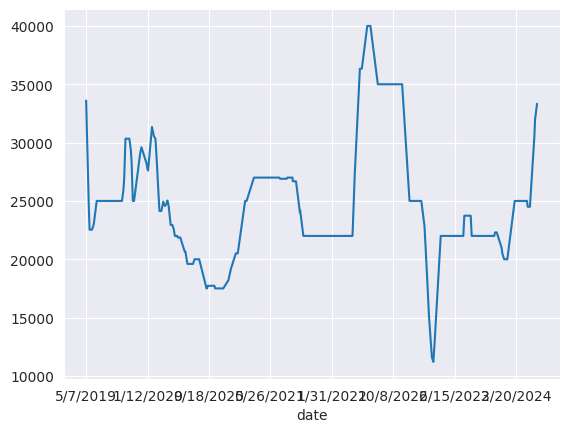

In [59]:
test_data.plot()

<Axes: xlabel='date'>

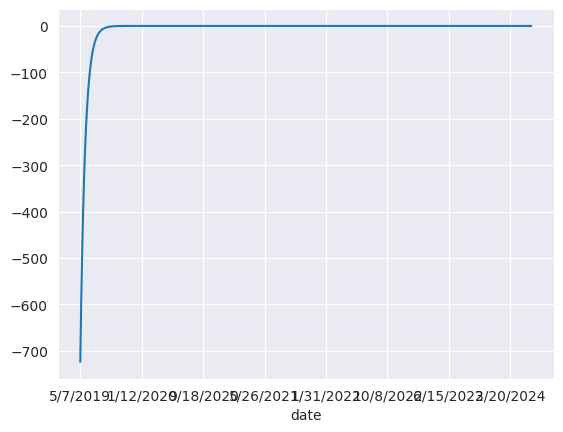

In [60]:
fc_series.plot()

In [61]:
diff_data.cumsum()

date
8/16/2007       66.666667
8/17/2007      133.333333
8/18/2007      200.000000
8/19/2007      266.666667
8/20/2007      333.333333
                 ...     
5/2/2019     20100.000000
5/3/2019     19333.333333
5/4/2019     18566.666667
5/5/2019     17800.000000
5/6/2019     17033.333333
Name: price, Length: 4282, dtype: float64

In [62]:
diff_data = fc_series.copy()

reverted_data = test_data.iloc[0] + diff_data.cumsum()
# Compute the cumulative sum to revert the diff transformation


In [63]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[str(col)+'_forecast'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

<Axes: xlabel='date'>

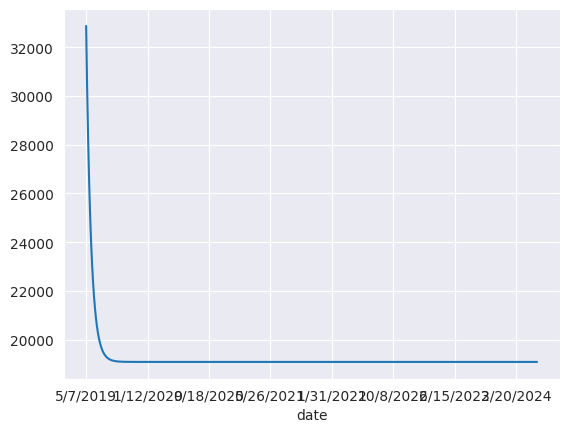

In [64]:
reverted_data.plot()

In [65]:
test_data

date
5/7/2019     33600.000000
5/8/2019     32833.333333
5/9/2019     31966.666667
5/10/2019    31100.000000
5/11/2019    30233.333333
                 ...     
5/11/2024    32666.666667
5/12/2024    32833.333333
5/13/2024    33000.000000
5/14/2024    33166.666667
5/15/2024    33333.333333
Name: price, Length: 1836, dtype: float64

<Axes: xlabel='date'>

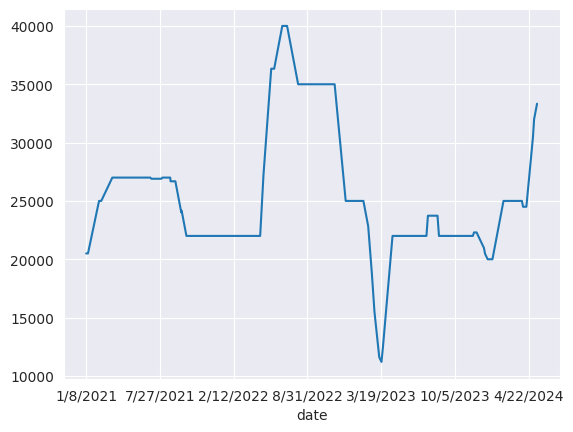

In [66]:
df1[int(len(df1)*0.8):].plot()

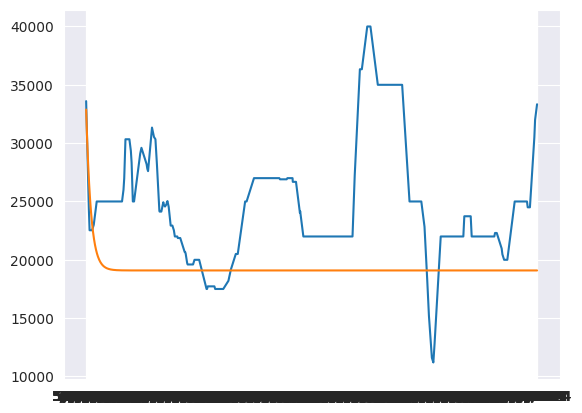

In [67]:
#plot the predictions for validation set
# plt.plot(train_data_inverse, label='Train')
plt.plot(test_data, label='Valid')
plt.plot(reverted_data, label='Prediction')
plt.show()

Đánh giá mô hình với RMSE và MAPE

In [68]:
rmse = sqrt(mean_squared_error(test_data.values, reverted_data))
rmse

7574.473427432601

In [69]:
from sklearn.metrics import mean_absolute_percentage_error

def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast) * 100  # MAPE     # ME
    rmse = np.mean((forecast - actual)**2)**.5  # RMS
    return({'mape':mape, 'rmse':rmse})

In [70]:
forecast_accuracy(test_data.values, reverted_data.values)

{'mape': 31.05334458583692, 'rmse': 7574.473427432601}

In [71]:
import joblib
from google.colab import drive

file_name = "arima_gia_cam.joblib"
drive.mount('/content/drive')

joblib.dump(model_arima, '/content/drive/MyDrive/model/' + file_name)

Mounted at /content/drive


['/content/drive/MyDrive/model/arima_gia_cam.joblib']